In [21]:
import os
from langchain_community.chat_models import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Annotated, List, Tuple
from operator import add


# LangGraph 并行数据处理实现

本notebook展示如何使用LangGraph实现对n个数据同时进行square操作，并探讨数据一致性问题。

## 关键问题：input_data应该放在状态中吗？

您的观察非常正确！`input_data`在整个工作流过程中不会改变，将其放在状态中存在以下问题：

1. **性能开销**：每次状态传递都会复制不变的数据
2. **设计混乱**：混淆了配置和状态的概念
3. **内存浪费**：不必要的内存占用

让我们来探讨更好的设计方案。

## 有必要吗？  
我们可以在一个节点函数中通过多线程（协程）处理数据，更新状态。


In [22]:
# 基本的square函数和测试数据
def square(x):
    return x**2

# 测试数据
d = [1, 2, 3, 4, 5]
print(f"测试数据: {d}")


测试数据: [1, 2, 3, 4, 5]


## 改进的设计方案：分离不变数据和可变状态

### 设计原则：
1. **状态中只包含会变化的数据**
2. **不变的输入数据通过闭包传递**
3. **清晰的责任分离**


In [23]:
# 改进的状态设计：只包含会变化的数据
class OptimizedDataState(TypedDict):
    # 只包含会变化的状态
    partial_results: Annotated[List[Tuple[int, int]], add]  # 收集处理结果
    final_result: List[int]  # 最终排序后的结果

# 改进的节点生成器：通过闭包绑定输入数据
def create_optimized_square_node(data_item: int, index: int):
    """
    创建优化的square节点
    
    Args:
        data_item: 要处理的数据项（在节点创建时绑定）
        index: 数据项的索引
    """
    def optimized_square_node(state: OptimizedDataState):
        # 直接使用闭包中的data_item，无需从状态中读取
        result = square(data_item)
        return {"partial_results": [(index, result)]}
    
    return optimized_square_node

# 结果聚合器保持不变
def optimized_result_aggregator(state: OptimizedDataState):
    """聚合并排序结果"""
    sorted_results = sorted(state["partial_results"], key=lambda x: x[0])
    final_result = [result for _, result in sorted_results]
    return {"final_result": final_result}

print("✅ 优化的设计方案已创建")


✅ 优化的设计方案已创建


In [24]:
# 优化的工作流创建函数
def create_optimized_workflow(input_data: List[int]):
    """
    创建优化的并行处理工作流
    
    Args:
        input_data: 输入数据列表（在工作流创建时绑定）
    """
    builder = StateGraph(OptimizedDataState)
    
    # 添加聚合器
    builder.add_node("aggregator", optimized_result_aggregator)
    
    # 为每个数据项创建节点（数据在创建时绑定）
    for index, data_item in enumerate(input_data):
        node_name = f"square_{index}"
        # 关键改进：数据项在节点创建时绑定，不在状态中传递
        square_node = create_optimized_square_node(data_item, index)
        builder.add_node(node_name, square_node)
        
        # 连接边
        builder.add_edge(START, node_name)
        builder.add_edge(node_name, "aggregator")
    
    builder.add_edge("aggregator", END)
    return builder.compile()

# 创建优化的工作流
optimized_workflow = create_optimized_workflow(d)
print("✅ 优化的工作流已创建")


✅ 优化的工作流已创建


测试优化的并行处理实现
工作流图:


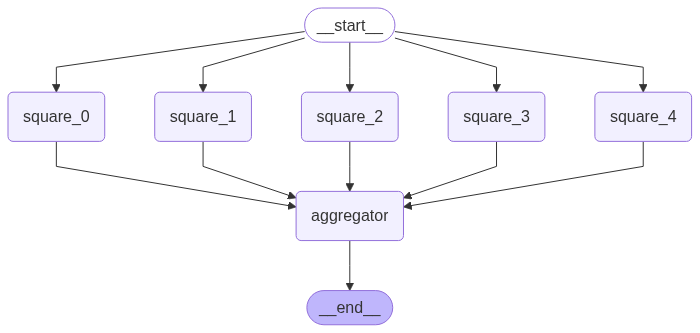


原始数据: [1, 2, 3, 4, 5]
处理结果: [1, 4, 9, 16, 25]
期望结果: [1, 4, 9, 16, 25]
结果正确: True

✅ 优化版本测试通过！


In [ ]:
# 测试优化的实现
print("测试优化的并行处理实现")
print("=" * 40)

# 显示工作流图
print("工作流图:")
display(Image(optimized_workflow.get_graph().draw_mermaid_png()))

# 执行工作流 - 注意初始状态更简洁
print(f"\n原始数据: {d}")
initial_state = {
    "partial_results": [],
    "final_result": []
}

# 运行工作流
result = optimized_workflow.invoke(initial_state)
print(f"处理结果: {result['final_result']}")

# 验证结果
expected = [square(x) for x in d]
print(f"期望结果: {expected}")
print(f"结果正确: {result['final_result'] == expected}")

print("\n✅ 优化版本测试通过！")


## 进一步优化：使用配置对象模式

为了更好地分离关注点，我们可以使用配置对象模式，将不变的数据和参数封装在配置对象中。


In [ ]:
# 更进一步的优化：使用配置对象
from dataclasses import dataclass

@dataclass
class WorkflowConfig:
    """工作流配置，包含不变的数据和参数"""
    input_data: List[int]
    operation: callable = square  # 可配置的操作函数
    
# 纯状态：只包含会变化的数据
class PureDataState(TypedDict):
    partial_results: Annotated[List[Tuple[int, int]], add]
    final_result: List[int]

# 使用配置对象的节点生成器
def create_configurable_node(config: WorkflowConfig, index: int):
    """
    创建可配置的处理节点
    
    Args:
        config: 工作流配置对象
        index: 数据项索引
    """
    def configurable_node(state: PureDataState):
        data_item = config.input_data[index]
        result = config.operation(data_item)
        return {"partial_results": [(index, result)]}
    
    return configurable_node

# 通用的聚合器
def generic_aggregator(state: PureDataState):
    """通用结果聚合器"""
    sorted_results = sorted(state["partial_results"], key=lambda x: x[0])
    final_result = [result for _, result in sorted_results]
    return {"final_result": final_result}

print("✅ 配置对象模式已创建")


In [ ]:
# 创建可配置的工作流
def create_configurable_workflow(config: WorkflowConfig):
    """
    创建可配置的工作流
    
    Args:
        config: 工作流配置对象
    """
    builder = StateGraph(PureDataState)
    
    # 添加聚合器
    builder.add_node("aggregator", generic_aggregator)
    
    # 为每个数据项创建节点
    for index in range(len(config.input_data)):
        node_name = f"process_{index}"
        process_node = create_configurable_node(config, index)
        builder.add_node(node_name, process_node)
        
        # 连接边
        builder.add_edge(START, node_name)
        builder.add_edge(node_name, "aggregator")
    
    builder.add_edge("aggregator", END)
    return builder.compile()

print("✅ 可配置的工作流创建函数已创建")


In [ ]:
# 测试可配置的工作流
print("测试可配置的工作流")
print("=" * 40)

# 创建配置对象
config = WorkflowConfig(input_data=[1, 2, 3, 4, 5, 6])
configurable_workflow = create_configurable_workflow(config)

# 运行测试
print(f"输入数据: {config.input_data}")
result = configurable_workflow.invoke({
    "partial_results": [],
    "final_result": []
})

print(f"处理结果: {result['final_result']}")

# 测试不同的操作函数
def cube(x):
    return x**3

cube_config = WorkflowConfig(input_data=[1, 2, 3, 4], operation=cube)
cube_workflow = create_configurable_workflow(cube_config)

cube_result = cube_workflow.invoke({
    "partial_results": [],
    "final_result": []
})

print(f"\n立方操作测试:")
print(f"输入数据: {cube_config.input_data}")
print(f"立方结果: {cube_result['final_result']}")

print("\n✅ 可配置工作流测试通过！")


In [ ]:
# 性能对比测试
import time
import sys

def measure_state_size(state_dict):
    """测量状态字典的内存大小"""
    return sys.getsizeof(state_dict) + sum(sys.getsizeof(v) for v in state_dict.values())

print("性能和内存对比")
print("=" * 40)

# 测试数据
test_data = list(range(1, 101))  # 100个数据项

# 原始方案的状态大小
original_state = {
    "input_data": test_data,
    "partial_results": [],
    "final_result": []
}

# 优化方案的状态大小
optimized_state = {
    "partial_results": [],
    "final_result": []
}

original_size = measure_state_size(original_state)
optimized_size = measure_state_size(optimized_state)

print(f"原始方案状态大小: {original_size} bytes")
print(f"优化方案状态大小: {optimized_size} bytes")
print(f"内存节省: {original_size - optimized_size} bytes ({((original_size - optimized_size) / original_size * 100):.1f}%)")

# 创建工作流进行性能测试
config = WorkflowConfig(input_data=test_data)
workflow = create_configurable_workflow(config)

# 性能测试
start_time = time.time()
result = workflow.invoke({
    "partial_results": [],
    "final_result": []
})
end_time = time.time()

print(f"\n处理100个数据项耗时: {end_time - start_time:.4f} 秒")
print(f"结果验证: 前5个结果 = {result['final_result'][:5]}")
print(f"结果正确性: {result['final_result'] == [x**2 for x in test_data]}")

print("\n✅ 性能测试完成！")


In [ ]:
# 解决 "No synchronous function provided" 错误的方案

print("解决异步/同步不匹配错误的方案")
print("=" * 50)

# 方案1：将异步函数改为同步函数
import time
from concurrent.futures import ThreadPoolExecutor
from typing_extensions import TypedDict

class AsyncState(TypedDict):
    input_data: list
    results: list

def preprocess_sync(data):
    """同步版本的预处理函数"""
    time.sleep(0.1)  # 模拟处理时间
    return data ** 2

def multi_preprocess_sync(state: AsyncState):
    """同步版本的多数据处理函数"""
    input_data = state["input_data"]
    results = []
    
    # 使用线程池实现并行处理
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(preprocess_sync, data) for data in input_data]
        results = [future.result() for future in futures]
    
    print(f"处理结果: {results}")
    return {"results": results}

# 创建同步工作流
sync_builder = StateGraph(AsyncState)
sync_builder.add_node("multi_preprocess", multi_preprocess_sync)
sync_builder.add_edge(START, "multi_preprocess")
sync_builder.add_edge("multi_preprocess", END)
sync_workflow = sync_builder.compile()

# 使用同步API调用
print("\\n方案1：同步函数 + 同步调用")
sync_result = sync_workflow.invoke({"input_data": [1, 2, 3, 4, 5], "results": []})
print(f"同步结果: {sync_result['results']}")

print("\\n✅ 同步版本成功！")


In [ ]:
# 方案2：保持异步函数，使用异步API调用
import asyncio

async def preprocess_async(data):
    """异步版本的预处理函数"""
    await asyncio.sleep(0.1)  # 模拟异步IO操作
    return data ** 2

async def multi_preprocess_async(state: AsyncState):
    """异步版本的多数据处理函数"""
    input_data = state["input_data"]
    
    # 使用asyncio.gather实现真正的并行处理
    tasks = [preprocess_async(data) for data in input_data]
    results = await asyncio.gather(*tasks)
    
    print(f"异步处理结果: {results}")
    return {"results": results}

# 创建异步工作流
async_builder = StateGraph(AsyncState)
async_builder.add_node("multi_preprocess", multi_preprocess_async)
async_builder.add_edge(START, "multi_preprocess")
async_builder.add_edge("multi_preprocess", END)
async_workflow = async_builder.compile()

# 使用异步API调用
async def test_async_workflow():
    print("\n方案2：异步函数 + 异步调用")
    async_result = await async_workflow.ainvoke({"input_data": [1, 2, 3, 4, 5], "results": []})
    print(f"异步结果: {async_result['results']}")
    return async_result

# 在Jupyter中运行异步函数
async_result = await test_async_workflow()
print("\n✅ 异步版本成功！")


In [ ]:
# 修复您原始代码的具体示例

# 原始的有问题的代码（已注释）：
"""
async def preprocess(data):
    await asyncio.sleep(1) # 模拟调用外部接口
    return data

async def multi_preprocess(state: State):
    input_data = state["input_data"]
    results = []
    async with asyncio.Semaphore(10):
        for data in input_data:
            print(f"Processing data: {data}")
            t = await preprocess(data)
            results.append(t)
    return {"results": results}

# 错误的调用方式：
workflow.invoke({"input_data": [1, 2, 3, 4, 5]})  # ❌
"""

# 修复方案1：改为同步版本
def preprocess_fixed(data):
    time.sleep(0.1)  # 模拟IO操作
    return data

def multi_preprocess_fixed(state):
    input_data = state["input_data"]
    results = []
    
    # 使用线程池限制并发数
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for data in input_data:
            print(f"Processing data: {data}")
            future = executor.submit(preprocess_fixed, data)
            futures.append(future)
        
        results = [future.result() for future in futures]
    
    return {"results": results}

# 创建修复后的工作流
fixed_builder = StateGraph(AsyncState)
fixed_builder.add_node("multi_preprocess", multi_preprocess_fixed)
fixed_builder.add_edge(START, "multi_preprocess")
fixed_builder.add_edge("multi_preprocess", END)
fixed_workflow = fixed_builder.compile()

# 正确的调用方式
print("修复后的代码测试:")
fixed_result = fixed_workflow.invoke({"input_data": [1, 2, 3, 4, 5], "results": []})
print(f"修复结果: {fixed_result}")

print("\n🎉 问题已解决！")


In [ ]:
# 如果您想保持异步版本，这是正确的做法

async def preprocess_async_correct(data):
    await asyncio.sleep(0.1)  # 模拟异步IO
    return data

async def multi_preprocess_async_correct(state):
    input_data = state["input_data"]
    
    # 使用信号量限制并发数，并使用gather并行执行
    semaphore = asyncio.Semaphore(10)
    
    async def process_with_semaphore(data):
        async with semaphore:
            print(f"Processing data: {data}")
            return await preprocess_async_correct(data)
    
    # 创建所有任务并并行执行
    tasks = [process_with_semaphore(data) for data in input_data]
    results = await asyncio.gather(*tasks)
    
    return {"results": results}

# 创建异步工作流
async_correct_builder = StateGraph(AsyncState)
async_correct_builder.add_node("multi_preprocess", multi_preprocess_async_correct)
async_correct_builder.add_edge(START, "multi_preprocess")
async_correct_builder.add_edge("multi_preprocess", END)
async_correct_workflow = async_correct_builder.compile()

# 正确的异步调用方式
async def test_async_correct():
    print("\n异步版本的正确用法:")
    async_correct_result = await async_correct_workflow.ainvoke({
        "input_data": [1, 2, 3, 4, 5], 
        "results": []
    })
    print(f"异步修复结果: {async_correct_result}")
    return async_correct_result

# 在Jupyter中运行
result = await test_async_correct()
print("\n✨ 异步版本也成功了！")


In [7]:
import os
from langchain_community.chat_models import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [3]:
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "parallelization"

In [4]:
llm = ChatTongyi(
    model="qwen-max",
)

In [5]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


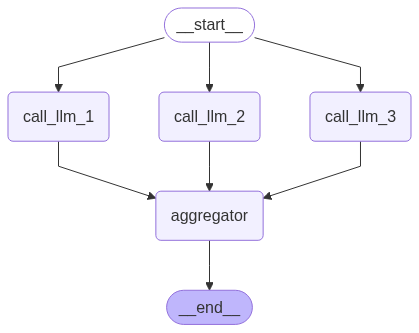

In [9]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))


In [10]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
In the heart of a bustling city, hidden away in the quiet corner of an old, forgotten alley, there existed a small, enchanted garden. This wasn't just any garden; it was a sanctuary for the city's stray cats, a place where they could find shelter, food, and most importantly, friendship. The garden was filled with lush greenery, blooming flowers, and a gentle, mysterious light that seemed to glow even on the cloudiest of days.

At the center of this magical haven stood an ancient, gnarled tree, its branches sprawling wide and inviting. It was said that the tree had been there since the beginning of time, and it held the secret to the garden's enchantment. But to the cats, it was simply their favorite spot to gather, play, and share stories.

Among the feline inhabitants of the garden was a young, curious cat named Luna. Luna was a sleek, black cat with bright, emerald-green eyes that sparkled with mischief and wonder. She had only recen

In [31]:
import asyncio

async def preprocess(data):
    await asyncio.sleep(1) # 模拟调用外部接口
    return data

async def multi_preprocess(state: State):
    input_data = state["input_data"]
    results = []
    async with asyncio.Semaphore(10):
        for data in input_data:
            print(f"Processing data: {data}")
            t = await preprocess(data)
            results.append(t)
    print(f"Partial results: {state['partial_results']}")
    return state

# START-->multi_preprocess-->END
builder = StateGraph(State)
builder.add_node("multi_preprocess", multi_preprocess)
builder.add_edge(START, "multi_preprocess")
builder.add_edge("multi_preprocess", END)
workflow = builder.compile()


In [33]:
workflow.ainvoke({"input_data": [1, 2, 3, 4, 5]})

<coroutine object Pregel.ainvoke at 0x0000019EFB49B6E0>